In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')


In [3]:
from modules.data_handling import load_and_normalize_data, split_dataset, create_validation_set
from modules.prediction_storage import store_predictions
from modules.fusion_methods import compute_neg_log_like, product_fusion, train_and_predict_fusion_method
from modules.model_training import train_and_predict_single_gp, train_expert, store_predictions_for_experts
from modules.phs import phs
from modules.bhs import bhs
from modules.model_training import train_joint_experts_shared_kernel


In [4]:
# ------------ Load and normalize data --------- #
# dataset_name = "concrete"
dataset_name = "pendulum"
split=3
X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name, 
                                                           split,
                                                        #    normalize_x_method="max-min",
                                                           normalize_x_method="z-score",
                                                           normalize_y=True)

print("training size: ", len(y_train))
print("test size: ", len(y_test))

training size:  567
test size:  63


In [5]:
n_experts = 3
val_incest = False

if val_incest:
    print("Experts are trained on all training data and validation data is taken from training splits")
    # we create the splits using all training data
    splits = split_dataset(X_train, y_train, n_splits=n_experts, with_replacement=False)
    # we create the validation from the same training data (= data incest)
    n_points_per_split = 5
    X_val, y_val = create_validation_set(splits, n_points_per_split)
else:
    print("Training data is split into two: one for training the experts and the other for the weights")
    validation_proportion = 0.1
    num_val_samples = int(validation_proportion*len(X_train))

    indices = np.arange(len(X_train))
    np.random.seed(11)
    np.random.shuffle(indices)  # Shuffle the data indices
    val_indices = indices[:num_val_samples]
    train_indices = indices[num_val_samples:]

    # training data is split into two so that we don't use twice the data for two learning/training stages (experts' training and the weight training)
    X_train_train = X_train[train_indices].copy()
    y_train_train = y_train[train_indices].copy()

    X_val = X_train[val_indices].copy()
    y_val = y_train[val_indices].copy()

    splits = split_dataset(X_train_train, y_train_train, n_splits=n_experts, with_replacement=False)

    

Training data is split into two: one for training the experts and the other for the weights


In [6]:
len(X_val)

56

In [7]:
for split in splits:
    print(split[0].shape[0])

171
171
169


In [8]:
kappa = 5
lambdaa = 5
training_iter = 100
lr = 0.1

joint_training = False

if joint_training:
    print("Experts are trained jointly")
    # ====== for joint training ========== #
    models, likelihood = train_joint_experts_shared_kernel(splits, kappa, lambdaa,
                                                           lr=lr,
                                                           training_iter=training_iter)
    experts = [(model,likelihood) for model in models]
    # ====== for independent training ==== #
else:
    print("Experts are trained independently")
    experts = []
    for X_split, y_split in splits:
        model, likelihood = train_expert(X_split, y_split, kappa, lambdaa,
                                         lr=lr,
                                         training_iter=training_iter)
        experts.append((model, likelihood))


# Store predictions for experts on the test set
mu_preds_test, std_preds_test, std_preds_prior_test = store_predictions_for_experts(experts, X_test)

# Compute negative log likelihood for experts
nlpd_experts = compute_neg_log_like(mu_preds_test, std_preds_test, y_test)
print(nlpd_experts, ", average NLPD: ",nlpd_experts.mean())

# Store predictions for experts on the validation set
mu_preds_val, std_preds_val, _ = store_predictions_for_experts(experts, X_val) # we don't need the prior predictive variances here...


Experts are trained independently
[0.13011609 0.31083645 0.20077764] , average NLPD:  0.2139100615443765


In [9]:
import torch
import random

# seed = 100
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

lr = 0.1
training_iter = 100
kappa = 5
lambdaa = 5

# ---------  Single GP using all training data ----- #
test_preds, _ = train_and_predict_single_gp(X_train, y_train, X_test, X_val, kappa, lambdaa,
                                            lr=lr,
                                            training_iter=training_iter,
                                            )
nlpd_single_gp = compute_neg_log_like(test_preds.mean.numpy().reshape(-1, 1), 
                                      np.sqrt(test_preds.variance.numpy().reshape(-1, 1)), y_test)
print("full GP: ", nlpd_single_gp.squeeze())

full GP:  -0.9938092870908969


# Testing the different stacking algorithms:
PHS with MCMC or VI (AutoDelta or AutoNormal)

BHS with MCMC or VI (AutoDelta or AutoNormal)

RFF-based PHS with MCMC or VI (coming soon...)

RFF-based BHS with MCMC or VI (coming soon...)

## PHS

### MCMC with NUTS

In [10]:
preds, lpd = train_and_predict_fusion_method(
                                phs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="mcmc",
                                parallel_mcmc=True,
                                show_progress=True,
                                show_summary=True,
                                )

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.07      0.67      1.06      0.00      2.00     98.04      1.05
kernel_length[1]      0.98      0.68      0.92      0.01      1.94     47.40      1.07
kernel_length[2]      0.86      0.60      0.75      0.01      1.66    182.59      1.01
 kernel_noise[0]      1.00      0.70      0.93      0.00      1.97     39.52      1.06
 kernel_noise[1]      0.82      0.60      0.72      0.01      1.59     91.63      1.05
 kernel_noise[2]      0.94      0.67      0.85      0.00      1.93     58.09      1.06
   kernel_var[0]      0.98      0.63      0.92      0.02      1.88    125.94      1.02
   kernel_var[1]      1.02      0.64      0.93      0.09      1.87     93.53      1.03
   kernel_var[2]      0.98      0.58      0.98      0.03      1.73    118.65      1.04
       w_un[0,0]     -1.33      1.27     -1.23     -3.22      0.76    383.11      1.00
       w_un[0,1]     -0.47      1.64     -

In [11]:
preds["w"].shape

(400, 3, 63)

PHS with MCMC:  -0.2640683619052514


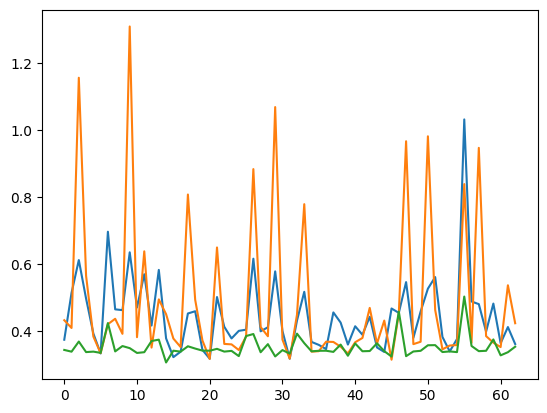

In [12]:
nlpd_phs_mcmc = -lpd.mean()
for i in range(n_experts):
    plt.plot(preds["w"].mean(0)[i,:])
print("PHS with MCMC: ", nlpd_phs_mcmc)    

### MAP with SVI AutoDelta

In [13]:
preds, lpd = train_and_predict_fusion_method(
                                phs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi="map",
                                show_progress=True,
                                )

100%|██████████| 3000/3000 [00:02<00:00, 1311.40it/s, init loss: 162.7012, avg. loss [2851-3000]: -925.0976]


In [14]:
preds["w"].shape

(1, 3, 63)

PHS with MAP:  -0.22937971193982992


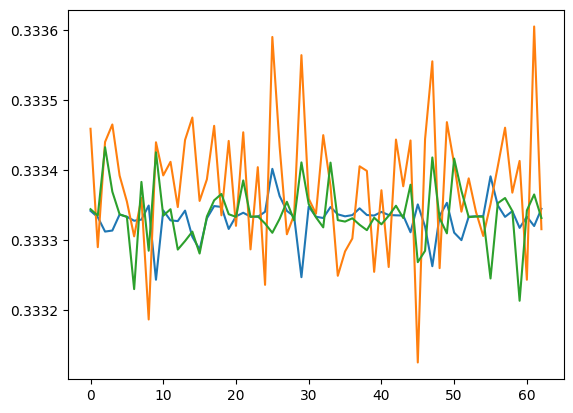

In [15]:
nlpd_phs_map = -lpd.mean()
for i in range(n_experts):
    plt.plot(preds["w"].mean(0)[i,:])
print("PHS with MAP: ", nlpd_phs_map)   

### Approximate Gaussian posterior with SVI AutoNormal

In [16]:
preds, lpd = train_and_predict_fusion_method(
                                phs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi="normal",
                                show_progress=True,
                                )

100%|██████████| 3000/3000 [00:03<00:00, 986.94it/s, init loss: 334.5854, avg. loss [2851-3000]: -21.9536] 


In [17]:
preds["w"].shape

(400, 3, 63)

PHS with Normal:  -0.2316868914648718


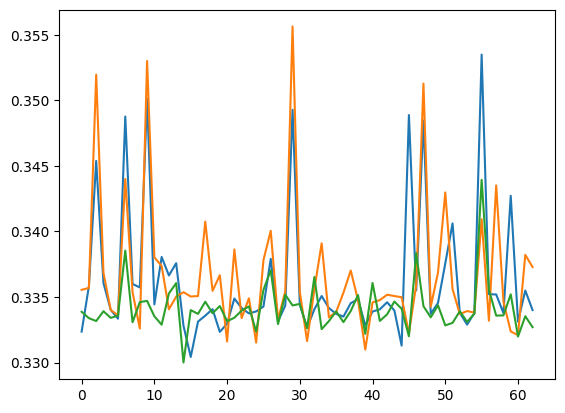

In [18]:
nlpd_phs_normal = -lpd.mean()
for i in range(n_experts):
    plt.plot(preds["w"].mean(0)[i,:])
print("PHS with Normal: ", nlpd_phs_normal)  

## BHS

### MCMC with NUTS

In [19]:
preds, lpd = train_and_predict_fusion_method(
                                bhs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="mcmc",
                                parallel_mcmc=True,
                                show_progress=True,
                                )

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
preds["w"].shape

(400, 63, 3)

BHS with MCMC:  -0.07830969827310588


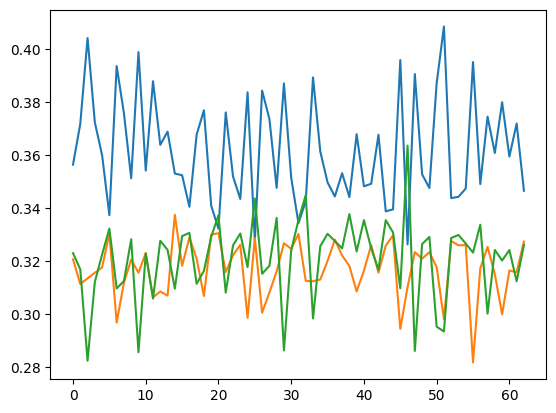

In [21]:
nlpd_bhs_mcmc = -lpd.mean()
for i in range(n_experts):
    plt.plot(preds["w"].mean(0).T[i,:])
print("BHS with MCMC: ", nlpd_bhs_mcmc)  

### MAP with SVI AutoDelta

In [23]:
preds, lpd = train_and_predict_fusion_method(
                                bhs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi="map",
                                show_progress=True,
                                )

100%|██████████| 3000/3000 [00:02<00:00, 1307.17it/s, init loss: 167.4741, avg. loss [2851-3000]: -919.9558]


In [24]:
preds["w"].shape

(1, 63, 3)

BHS with MAP:  -0.07518216432195886


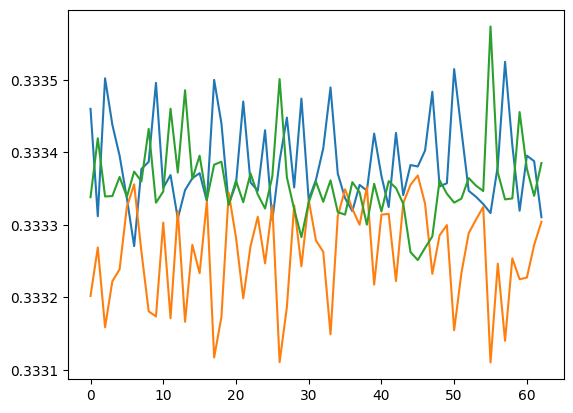

In [25]:
nlpd_bhs_map = -lpd.mean()
for i in range(n_experts):
    plt.plot(preds["w"].mean(0).T[i,:])
print("BHS with MAP: ", nlpd_bhs_map)  

### Approximate Gaussian posterior with SVI AutoNormal

In [26]:
preds, lpd = train_and_predict_fusion_method(
                                bhs,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi="normal",
                                show_progress=True,
                                )

100%|██████████| 3000/3000 [00:03<00:00, 971.13it/s, init loss: 339.3186, avg. loss [2851-3000]: -13.5961] 


In [27]:
preds["w"].shape

(400, 63, 3)

BHS with Normal:  -0.07574386599431729


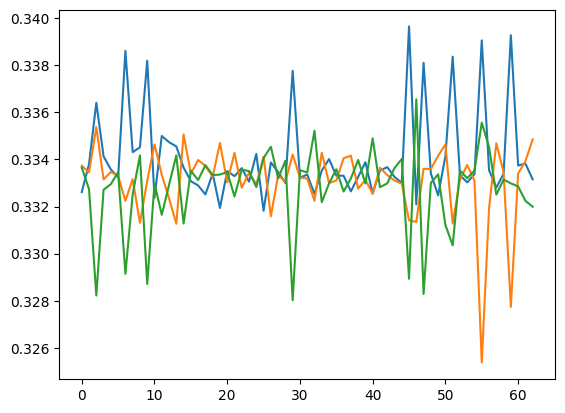

In [28]:
nlpd_bhs_normal = -lpd.mean()
for i in range(n_experts):
    plt.plot(preds["w"].mean(0).T[i,:])
print("BHS with Normal: ", nlpd_bhs_normal)  

# With RFF-GPs (only in the stacking part)

In [29]:
from modules.phs import phs_with_rff
from modules.bhs import bhs_with_rff
from modules.common import train_stacking, train_stacking_with_svi

## PHS

### NUTS

In [30]:
samples = train_stacking(
               phs_with_rff,
               X_val,
               mu_preds_val,
               std_preds_val,
               y_val,
               parallel=True,
               show_progress=True,
               show_summary=True,
               )

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       ell_logw[0,0]      0.76      0.57      0.60      0.10      1.54     53.83      1.04
       ell_logw[0,1]      0.70      0.63      0.48      0.07      1.63     22.29      1.22
       ell_logw[0,2]      0.87      0.58      0.72      0.17      1.71     71.48      1.06
       ell_logw[0,3]      0.78      0.59      0.70      0.04      1.64     30.05      1.11
       ell_logw[0,4]      0.98      0.58      0.91      0.11      1.71     76.21      1.03
       ell_logw[0,5]      0.60      0.55      0.45      0.05      1.52     12.93      1.18
       ell_logw[0,6]      0.65      0.54      0.52      0.06      1.42     13.15      1.18
       ell_logw[0,7]      0.55      0.54      0.34      0.04      1.39     10.73      1.19
       ell_logw[0,8]      0.81      0.56      0.65      0.09      1.56     27.74      1.16
       ell_logw[1,0]      0.84      0.63      0.70      0.15      1.80     45.67      1.0

In [31]:
%%script true
samples["w"].shape

In [32]:
%%script true
for i in range(n_experts):
    plt.plot(samples_phs_with_rff_mcmc["w"].mean(0)[i,:])

In [33]:
from numpyro.infer import Predictive
from jax.random import PRNGKey
from jax.nn import logsumexp

predictive = Predictive(phs_with_rff, samples)
preds = predictive(
    PRNGKey(0),
    X=X_test,
    mu_preds=mu_preds_test,
    std_preds=std_preds_test,
    y_val=y_test,
)


In [42]:
preds["w"].shape

(400, 3, 63)

NLPD NUTS:  -0.23860658129770682


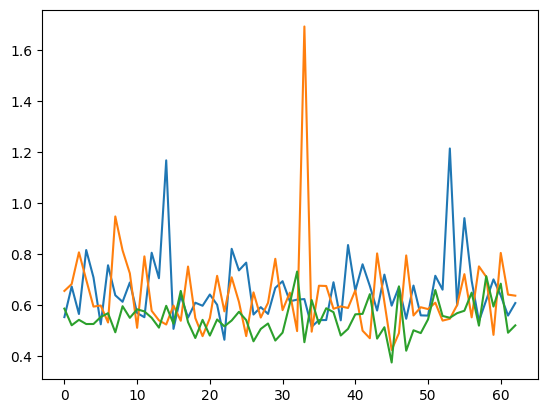

In [43]:
nlpd_phs_rff_mcmc = -np.mean(
    logsumexp(preds["lpd_point"], axis=0) - np.log(preds["lpd_point"].shape[0])
)
print("NLPD NUTS: ", nlpd_phs_rff_mcmc)

for i in range(n_experts):
    plt.plot(preds['w'].mean(0)[i,:])

In [39]:
# comprobando que obtenemos los mismos resultados con esta funcion
preds, lpd = train_and_predict_fusion_method(
                                phs_with_rff,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="mcmc",
                                gp_method="rff",
                                parallel_mcmc=True,
                                show_progress=True,
                                show_summary=True,
                                )

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       ell_logw[0,0]      0.76      0.57      0.60      0.10      1.54     53.83      1.04
       ell_logw[0,1]      0.70      0.63      0.48      0.07      1.63     22.29      1.22
       ell_logw[0,2]      0.87      0.58      0.72      0.17      1.71     71.48      1.06
       ell_logw[0,3]      0.78      0.59      0.70      0.04      1.64     30.05      1.11
       ell_logw[0,4]      0.98      0.58      0.91      0.11      1.71     76.21      1.03
       ell_logw[0,5]      0.60      0.55      0.45      0.05      1.52     12.93      1.18
       ell_logw[0,6]      0.65      0.54      0.52      0.06      1.42     13.15      1.18
       ell_logw[0,7]      0.55      0.54      0.34      0.04      1.39     10.73      1.19
       ell_logw[0,8]      0.81      0.56      0.65      0.09      1.56     27.74      1.16
       ell_logw[1,0]      0.84      0.63      0.70      0.15      1.80     45.67      1.0

NLPD MCMC:  -0.23860658129770682


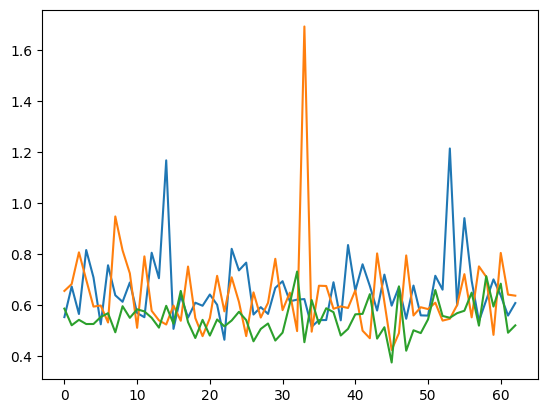

In [41]:
for i in range(n_experts):
    plt.plot(preds["w"].mean(0)[i,:])
print("NLPD MCMC: ", -lpd.mean())  

### SVI AutoDelta

In [44]:
samples = train_stacking_with_svi(
               phs_with_rff,
               X_val,
               mu_preds_val,
               std_preds_val,
               y_val,
               guide_svi="map",
               progress_bar=True,
               )

100%|██████████| 3000/3000 [00:01<00:00, 2101.59it/s, init loss: 276.7533, avg. loss [2851-3000]: 242.6409]


In [45]:
from numpyro.infer import Predictive
from jax.random import PRNGKey
from jax.nn import logsumexp

predictive = Predictive(phs_with_rff, samples)
preds = predictive(
    PRNGKey(0),
    X=X_test,
    mu_preds=mu_preds_test,
    std_preds=std_preds_test,
    y_val=y_test,
)

In [46]:
preds["w"].shape

(1, 3, 63)

NLPD MAP:  -0.28816678370350796


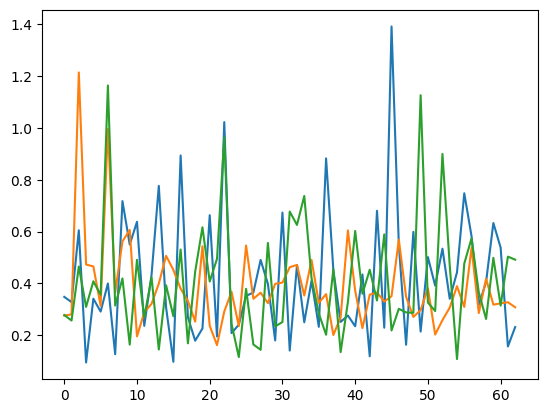

In [47]:
nlpd_phs_rff_map = -np.mean(
    logsumexp(preds["lpd_point"], axis=0) - np.log(preds["lpd_point"].shape[0])
)
print("NLPD MAP: ", nlpd_phs_rff_map)

for i in range(n_experts):
    plt.plot(preds['w'].mean(0)[i,:])

100%|██████████| 3000/3000 [00:01<00:00, 2248.26it/s, init loss: 276.7533, avg. loss [2851-3000]: 242.6409]


NLPD MAP:  -0.28816678370350796


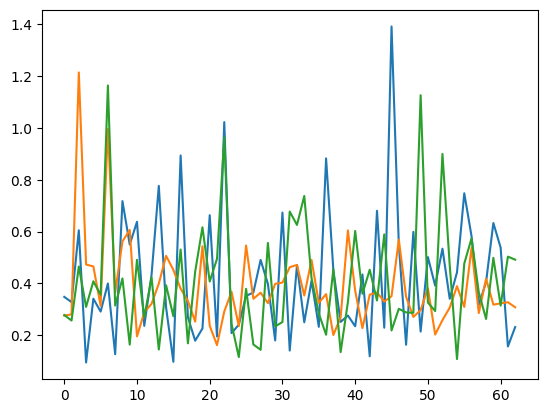

In [48]:
# comprobando que obtenemos los mismos resultados con esta funcion
preds, lpd = train_and_predict_fusion_method(
                                phs_with_rff,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi= "map",
                                gp_method="rff",
                                show_progress=True,
                                )
for i in range(n_experts):
    plt.plot(preds["w"].mean(0)[i,:])
print("NLPD MAP: ", -lpd.mean())  


### SVI AutoNormal

In [49]:
samples = train_stacking_with_svi(
               phs_with_rff,
               X_val,
               mu_preds_val,
               std_preds_val,
               y_val,
               guide_svi="normal",
               progress_bar=True,
               )

100%|██████████| 3000/3000 [00:02<00:00, 1406.12it/s, init loss: 597.6604, avg. loss [2851-3000]: -22.4458]


In [50]:
from numpyro.infer import Predictive
from jax.random import PRNGKey
from jax.nn import logsumexp

predictive = Predictive(phs_with_rff, samples)
preds = predictive(
    PRNGKey(0),
    X=X_test,
    mu_preds=mu_preds_test,
    std_preds=std_preds_test,
    y_val=y_test,
)

In [51]:
preds["w"].shape

(400, 3, 63)

NLPD Normal:  -0.23736232389559572


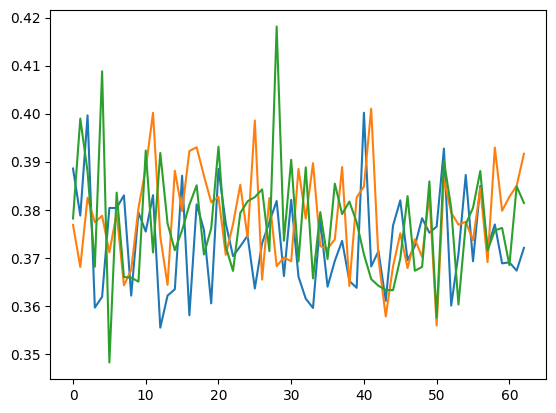

In [52]:
nlpd_phs_rff_normal = -np.mean(
    logsumexp(preds["lpd_point"], axis=0) - np.log(preds["lpd_point"].shape[0])
)
print("NLPD Normal: ", nlpd_phs_rff_normal)

for i in range(n_experts):
    plt.plot(preds['w'].mean(0)[i,:])

100%|██████████| 3000/3000 [00:02<00:00, 1372.64it/s, init loss: 597.6604, avg. loss [2851-3000]: -22.4458]


NLPD Normal:  -0.23736232389559572


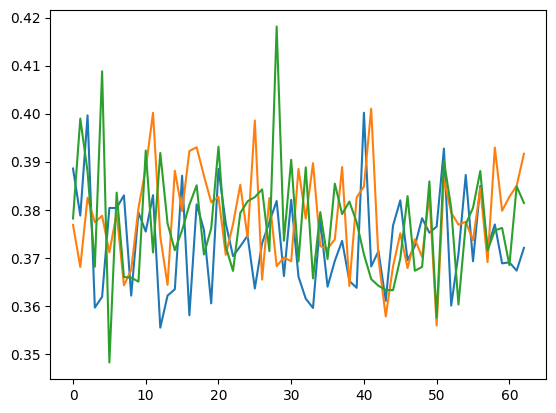

In [54]:
# comprobando que obtenemos los mismos resultados con esta funcion
preds, lpd = train_and_predict_fusion_method(
                                phs_with_rff,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi= "normal",
                                gp_method="rff",
                                show_progress=True,
                                )
for i in range(n_experts):
    plt.plot(preds["w"].mean(0)[i,:])
print("NLPD Normal: ", -lpd.mean())  

## BHS

### NUTS

In [55]:
samples = train_stacking(
               bhs_with_rff,
               X_val,
               mu_preds_val,
               std_preds_val,
               y_val,
               parallel=True,
               show_progress=True,
               show_summary=True,
               )

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
       ell_w[0,0]      0.75      0.57      0.58      0.04      1.67     43.00      1.08
       ell_w[0,1]      0.70      0.59      0.54      0.02      1.49     41.64      1.11
       ell_w[0,2]      0.81      0.50      0.75      0.06      1.48    172.46      1.01
       ell_w[0,3]      0.72      0.53      0.59      0.05      1.51     84.54      1.10
       ell_w[0,4]      0.69      0.64      0.54      0.00      1.61     20.20      1.13
       ell_w[0,5]      0.69      0.56      0.55      0.01      1.41    137.57      1.03
       ell_w[0,6]      0.75      0.55      0.57      0.04      1.52     68.17      1.04
       ell_w[0,7]      0.68      0.56      0.52      0.02      1.47     38.55      1.14
       ell_w[0,8]      0.85      0.56      0.78      0.05      1.68     86.83      1.02
       ell_w[1,0]      0.93      0.59      0.85      0.11      1.72     59.04      1.06
       ell_w[1,1]      0.84    

In [56]:
from numpyro.infer import Predictive
from jax.random import PRNGKey
from jax.nn import logsumexp

predictive = Predictive(bhs_with_rff, samples)
preds = predictive(
    PRNGKey(0),
    X=X_test,
    mu_preds=mu_preds_test,
    std_preds=std_preds_test,
    y_val=y_test,
)

In [57]:
preds["w"].shape

(400, 63, 3)

NLPD NUTS:  -0.07612197044706517


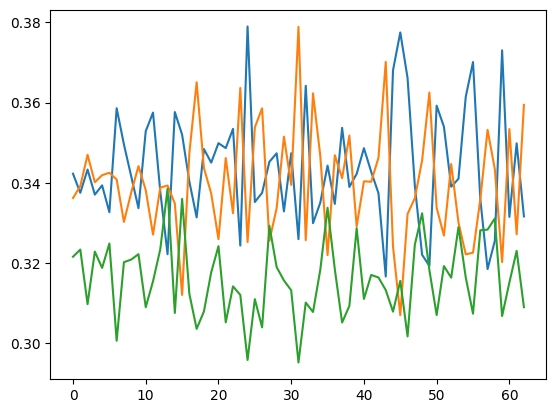

In [58]:
nlpd_bhs_rff_mcmc = -np.mean(
    logsumexp(preds["lpd_point"], axis=0) - np.log(preds["lpd_point"].shape[0])
)
print("NLPD NUTS: ", nlpd_bhs_rff_mcmc)

for i in range(n_experts):
    plt.plot(preds['w'].mean(0).T[i,:])

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
       ell_w[0,0]      0.75      0.57      0.58      0.04      1.67     43.00      1.08
       ell_w[0,1]      0.70      0.59      0.54      0.02      1.49     41.64      1.11
       ell_w[0,2]      0.81      0.50      0.75      0.06      1.48    172.46      1.01
       ell_w[0,3]      0.72      0.53      0.59      0.05      1.51     84.54      1.10
       ell_w[0,4]      0.69      0.64      0.54      0.00      1.61     20.20      1.13
       ell_w[0,5]      0.69      0.56      0.55      0.01      1.41    137.57      1.03
       ell_w[0,6]      0.75      0.55      0.57      0.04      1.52     68.17      1.04
       ell_w[0,7]      0.68      0.56      0.52      0.02      1.47     38.55      1.14
       ell_w[0,8]      0.85      0.56      0.78      0.05      1.68     86.83      1.02
       ell_w[1,0]      0.93      0.59      0.85      0.11      1.72     59.04      1.06
       ell_w[1,1]      0.84    

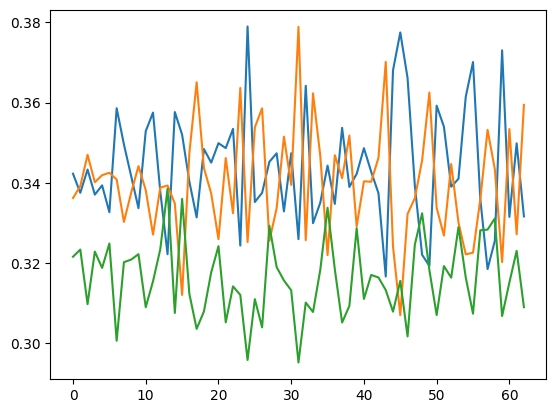

In [60]:
# comprobando que obtenemos los mismos resultados con esta funcion
preds, lpd = train_and_predict_fusion_method(
                                bhs_with_rff,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="mcmc",
                                gp_method="rff",
                                parallel_mcmc=True,
                                show_progress=True,
                                show_summary=True,
                                )
for i in range(n_experts):
    plt.plot(preds["w"].mean(0).T[i,:])
print("NLPD MCMC: ", -lpd.mean())  

### SVI AutoDelta

In [61]:
samples = train_stacking_with_svi(
               bhs_with_rff,
               X_val,
               mu_preds_val,
               std_preds_val,
               y_val,
               guide_svi="map",
               progress_bar=True,
               )

100%|██████████| 3000/3000 [00:01<00:00, 2169.29it/s, init loss: 175.9639, avg. loss [2851-3000]: 161.2129]


In [62]:
from numpyro.infer import Predictive
from jax.random import PRNGKey
from jax.nn import logsumexp

predictive = Predictive(bhs_with_rff, samples)
preds = predictive(
    PRNGKey(0),
    X=X_test,
    mu_preds=mu_preds_test,
    std_preds=std_preds_test,
    y_val=y_test,
)

In [63]:
preds["w"].shape

(1, 63, 3)

NLPD Map:  -0.07388527105274538


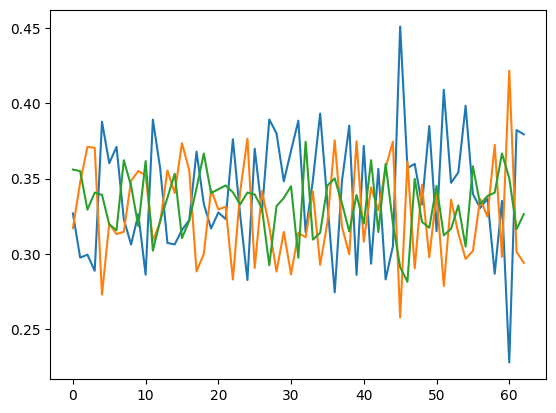

In [64]:
nlpd_bhs_rff_map = -np.mean(
    logsumexp(preds["lpd_point"], axis=0) - np.log(preds["lpd_point"].shape[0])
)
print("NLPD Map: ", nlpd_bhs_rff_map)

for i in range(n_experts):
    plt.plot(preds['w'].mean(0).T[i,:])

100%|██████████| 3000/3000 [00:01<00:00, 2832.67it/s, init loss: 175.9639, avg. loss [2851-3000]: 161.2129]


NLPD MAP:  -0.07388527105274538


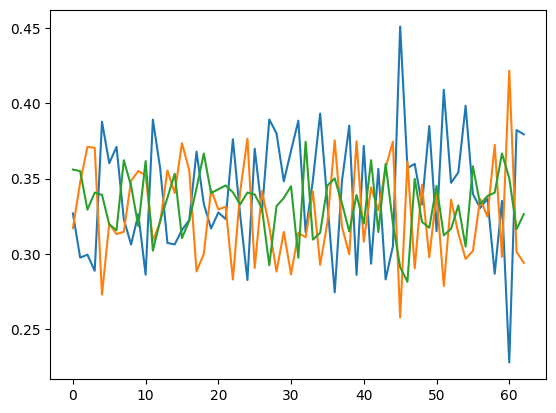

In [65]:
# comprobando que obtenemos los mismos resultados con esta funcion
preds, lpd = train_and_predict_fusion_method(
                                bhs_with_rff,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi="map",
                                gp_method="rff",
                                # parallel_mcmc=True,
                                show_progress=True,
                                # show_summary=True,
                                )
for i in range(n_experts):
    plt.plot(preds["w"].mean(0).T[i,:])
print("NLPD MAP: ", -lpd.mean())  

### SVI AutoNormal

In [66]:
samples = train_stacking_with_svi(
               bhs_with_rff,
               X_val,
               mu_preds_val,
               std_preds_val,
               y_val,
               guide_svi="normal",
               progress_bar=True,
               )


from numpyro.infer import Predictive
from jax.random import PRNGKey
from jax.nn import logsumexp

predictive = Predictive(bhs_with_rff, samples)
preds = predictive(
    PRNGKey(0),
    X=X_test,
    mu_preds=mu_preds_test,
    std_preds=std_preds_test,
    y_val=y_test,
)

100%|██████████| 3000/3000 [00:01<00:00, 1707.70it/s, init loss: 381.2027, avg. loss [2851-3000]: -21.4771]


In [67]:
preds["w"].shape

(400, 63, 3)

NLPD Normal:  -0.07301200669226256


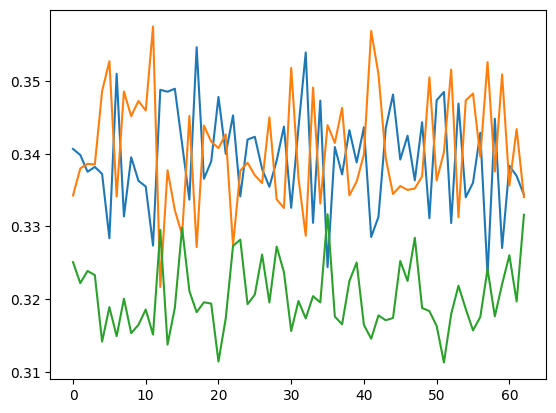

In [68]:
nlpd_bhs_rff_normal = -np.mean(
    logsumexp(preds["lpd_point"], axis=0) - np.log(preds["lpd_point"].shape[0])
)
print("NLPD Normal: ", nlpd_bhs_rff_normal)

for i in range(n_experts):
    plt.plot(preds['w'].mean(0).T[i,:])

100%|██████████| 3000/3000 [00:01<00:00, 1659.60it/s, init loss: 381.2027, avg. loss [2851-3000]: -21.4771]


NLPD MAP:  -0.07301200669226256


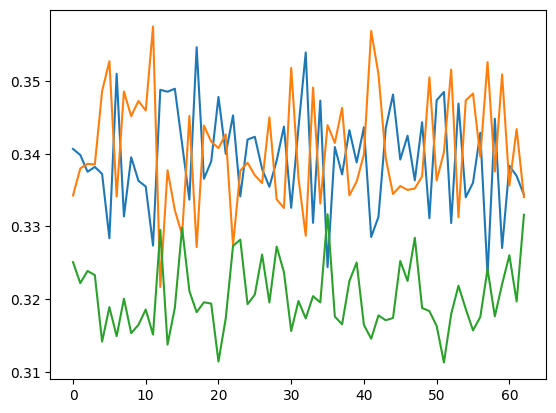

In [69]:
# comprobando que obtenemos los mismos resultados con esta funcion
preds, lpd = train_and_predict_fusion_method(
                                bhs_with_rff,
                                X_val,
                                mu_preds_val,
                                std_preds_val,
                                y_val,
                                X_test,
                                mu_preds_test,
                                std_preds_test,
                                y_test,
                                inference_method="svi",
                                guide_svi="normal",
                                gp_method="rff",
                                # parallel_mcmc=True,
                                show_progress=True,
                                # show_summary=True,
                                )
for i in range(n_experts):
    plt.plot(preds["w"].mean(0).T[i,:])
print("NLPD MAP: ", -lpd.mean())  